    Hyper parameter optimization of an LSTM model using Bayesian optimization method. The model is developed by `dl4seq`

In [2]:
import site
import os
dl4seq_path = os.getcwd().rsplit('\\',1)[0] + '\\'
site.addsitedir(dl4seq_path)  # so that this file can import stuff without it being in site-packages
print(f"Adding {dl4seq_path} to path")

In [3]:
#!python -m pip install git+https://github.com/AtrCheema/TSErrors.git
# uncomment above line if TSErrors is not installed. 
from TSErrors import FindErrors

In [4]:
from dl4seq import Model
from dl4seq.utils import make_model
from dl4seq.hyper_opt import HyperOpt
import pandas as pd
import numpy as np


**********Pytorch models could not be imported **********



In [5]:
fname = os.path.join(dl4seq_path, "dl4seq/data/data_30min.csv")
data=pd.read_csv(fname)
data.shape

(1446, 24)

In [6]:
data.head()

,Date_Time2,input1,input2,input3,input4,input5,input6,input7,input8,input9,...,target3,target4,target5,target6,target7,target8,target9,target10,target11,target12
0,6/19/2018 0:00,36.407149,19.321232,33.956059,19.780000,0.0,0.0,159.533333,0.960000,1002.856667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6/19/2018 0:30,35.562515,19.320124,33.950508,19.093333,0.0,0.0,86.596667,0.163333,1002.300000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6/19/2018 1:00,34.808016,19.319666,33.942532,18.733333,0.0,0.0,2.260000,0.080000,1001.973333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6/19/2018 1:30,30.645216,19.320406,33.931263,18.760000,0.0,0.0,62.710000,0.193333,1001.776667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6/19/2018 2:00,26.608980,19.326729,33.917961,18.633333,0.0,0.0,63.446667,0.510000,1001.743333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
inputs = ['input1', 'input2', 'input3', 'input4', 'input5', 'input6', 'input8',  'input11']
outputs = ['target5']

layers = {
    "LSTM": {"config": {"units": 64}},
    "Dense": {"config": {"units": 1, "activation": "relu"}},
    "Reshape": {"config": {"target_shape": (1,1)}}
}

dl4seq_args = {"inputs": inputs,
               "outputs": outputs,
               "lookback": 4,
               "val_data": "same",
               "test_fraction": 0.3,
               "layers": layers,
               "epochs": 500
               }

config = make_model(**dl4seq_args)
model = Model(config, data=data, verbosity=0)

In [8]:
history = model.train(indices="random")

D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


In [9]:
# The minimum validation loss acheived during training
np.min(history.history['val_loss'])

0.013944599777460098

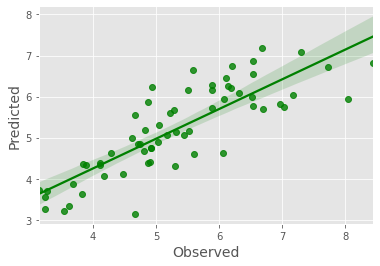

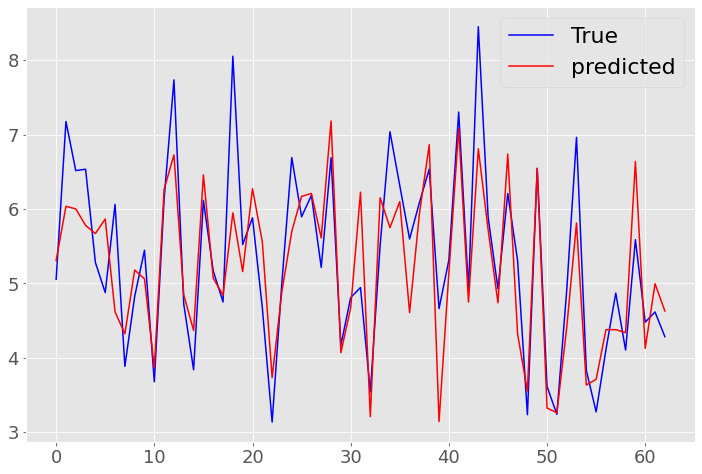

In [10]:
# Perfomance on validation data
t,p = model.predict(indices=model.test_indices)

Define parameter space for the parameters to be optimized

In [11]:
from skopt.space import Real, Categorical, Integer

dims = [Categorical([32, 64, 128, 256], name='lstm_units'),
        Integer(low=3, high=12, name='lookback'),
        Real(low=1e-5, high=0.01, name='learning_rate'),
        Categorical(categories=[8, 12, 16, 24, 32], name="batch_size"),
        Categorical(categories=["relu", "elu", "leakyrelu"], name="dense_actfn")
        ]

Define objective function. The parameters to be optimized (which have been declared above) will be in kwargs. We can use them in our objective function as we like.

In [12]:
def objective_fn(return_model=False,
                 title="bayes", # This will make sure that all optimization results will be stored in a single folder
                 **kwargs):

    layers = {
        "LSTM": {"config": {"units": int(kwargs["lstm_units"])}},
        "Dense": {"config": {"units": 1, "activation": kwargs["dense_actfn"]}},
        "Reshape": {"config": {"target_shape": (1,1)}}
    }

    config = make_model(
        inputs=inputs,
        outputs=outputs,
        lookback=int(kwargs["lookback"]),
        val_data="same",
        test_fraction=0.3,
        layers=layers,
        batch_size=int(kwargs["batch_size"]),
        lr=float(kwargs["learning_rate"]),
        epochs=500)

    model = Model(config,
                  data=data,
                  prefix=title,
                  verbosity=0)

    history = model.train(indices="random")

    mse = np.min(history.history['val_loss'])
    print(f"Validation mse {mse}")

    if return_model:
        return model
    return mse

initiate optimization problem.

In [13]:
opt = HyperOpt("bayes",
               model=objective_fn,
               param_space=dims,
               use_named_args=True,
               acq_func='EI',  # Expected Improvement.
               n_calls=50,     #number of iterations
               # acq_optimizer='auto',
               x0=[32, 5, 0.001, 8, "relu"],  # inital value of optimizing parameters
               n_random_starts=3,  # the number of random initialization points
               random_state=2
               )

Start optimization

D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.014554675668478012


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.00983125064522028


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.016472168266773224


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.012076866813004017


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.01449171919375658


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.013450190424919128


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.021607713773846626


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.016823293641209602


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.017797887325286865


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.017567619681358337


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.014095905236899853


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.009520284831523895


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.013527403585612774


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.010824999772012234


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.02802572026848793


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.02270890586078167


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.008832384832203388


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.008834959007799625


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.009609134867787361


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.010378307662904263


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.008147969841957092


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.030761685222387314


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.006128933746367693


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.01820727437734604


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.008837660774588585


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.0071402788162231445


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.018661674112081528


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.014240553602576256


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.013465716503560543


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.015939220786094666


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.015326252207159996


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.0385909304022789


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.011450686492025852


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.018805278465151787


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.008689222857356071


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.007652265019714832


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.01973297819495201


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.012371945194900036


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.008114762604236603


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.010205377824604511


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.007287687622010708


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.029271243140101433


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.020707622170448303


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.012186756357550621


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.0077107441611588


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.008861803449690342


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.010330649092793465


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.011318990960717201


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.010030483826994896


D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.008163606747984886
could not pickle results


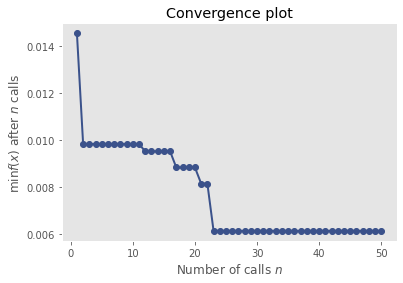

In [14]:
opt_results = opt.fit()

In [30]:
opt.gpmin_results['fun']

0.006128933746367693

In [27]:
x_iters = opt.gpmin_results['x_iters']
func_vals = opt.gpmin_results['func_vals']
idx = np.argmin(func_vals)
paras = x_iters[idx]
paras

[128, 12, 0.00391297699511148, 24, 'elu']

In [28]:
model = objective_fn(return_model=True, title=None,
                    lstm_units=128, lookback=12, learning_rate=0.00391297699511148, batch_size=24, dense_actfn="elu")

D:\mytools\dl4seq\dl4seq\main.py:731: UserWarning: Setting validation from 0.2 to 0.0
  warnings.warn(f"Setting validation from {self.data_config['val_fraction']} to 0.0")


Validation mse 0.006128933746367693


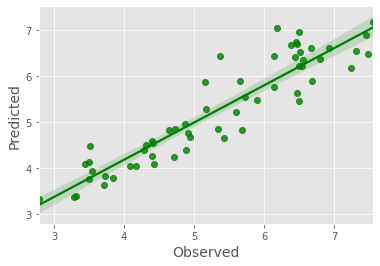

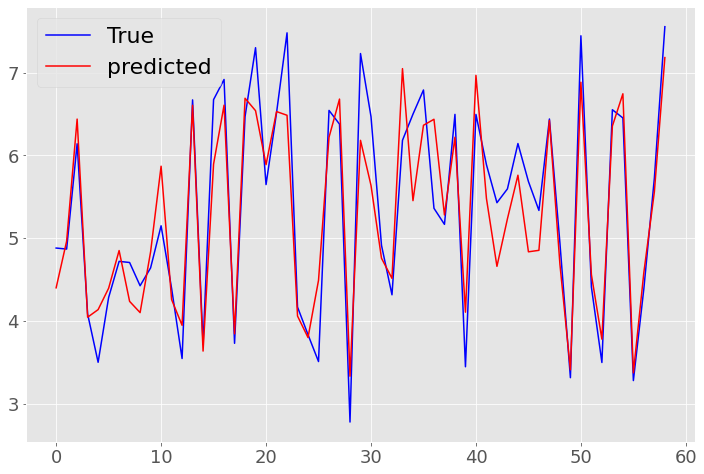

In [31]:
# Perfomance on validation data
t,p = model.predict(indices=model.test_indices)

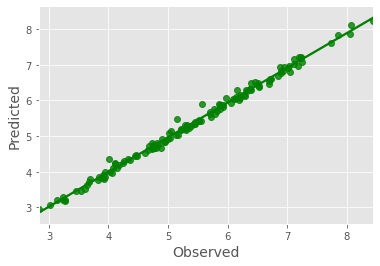

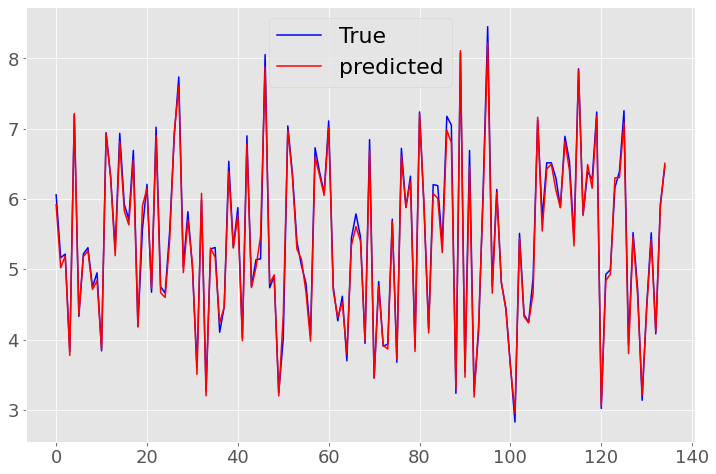

In [34]:
# Performance of the model on training data
t,p = model.predict(indices=model.train_indices, pref='train')

In [36]:
model.data_config['ignore_nans']

False

In [37]:
model.data_config['ignore_nans'] = True
model.data_config['ignore_nans']

True

In [39]:
# Performance of the model on training data
t,p = model.predict(pref='all')


********** Ignoring NANs in predictions **********



AssertionError: input still contains 36 nans

In [33]:
# The results with the best model are  are saved in following folder.
model.path

'D:\\mytools\\dl4seq\\examples\\results\\20201206_195131'